# Section IV - MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, manifold
from sklearn.utils import shuffle


import helpers as HL
import plot_functions as PL
import pickle_functions as PK

%load_ext autoreload
%autoreload 2

#constants
folder="mnist_pickles"
nb_samples = 1000

### ///////////////// TODO /////////////////////
- make import_func()
- make show_samples()
- make show_different_samples of numbers()
- fix heatmap x-axis labels to scientific notation with few decimals
- copy/paste discussion from report and modify

###### //////// B-list ////////
- fix image to be inside frame

## A. The dataset

### Description
The MNIST-dataset is 



In [2]:
# Loading dataset

# small dataset 1797 samples with 8x8=64 dim
#digits = datasets.load_digits(n_class=10)
# or
# original dataset 70.000 samples with 28x28=784 dim
digits = datasets.fetch_mldata('MNIST original', data_home="mnist")
inputs = digits.data
targets = digits.target
n_samples, n_features = inputs.shape
n_neighbors = 30
pixel_width = int(np.sqrt(inputs.shape[1]))

# shuffle data
inputs, targets = shuffle(inputs, targets, random_state=123)

print("Xshape: ", inputs.shape)
print("yshape: ", targets.shape)


Xshape:  (70000, 784)
yshape:  (70000,)


In [3]:
digits.data.imag[2].shape

(784,)

### Insight in the dataset

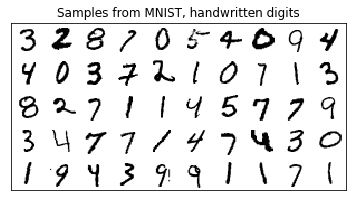

In [4]:
nb_images_per_row = 10
nb_images_per_col = 5
image = np.zeros(((pixel_width+2)*nb_images_per_col, (pixel_width+2)*nb_images_per_row))

for i in range(nb_images_per_col):
    x = (pixel_width+2)*i + 1
    
    for j in range (nb_images_per_row):
        y = (pixel_width+2)*j + 1
        image[x:x+pixel_width, y:y+pixel_width] = inputs[i*nb_images_per_row + j].reshape((pixel_width,pixel_width))
        
plt.imshow(image, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title("Samples from MNIST, handwritten digits")
plt.savefig("mnist_examples_of_data.pdf")
plt.show()

As you can see this is the dataset input is a picture with 8x8 pixels. low resolution

Next we will look as some local variation in the data within the same classes/digits

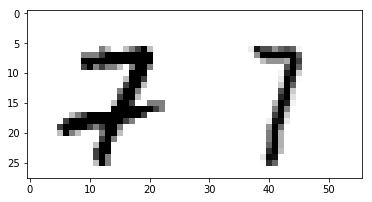

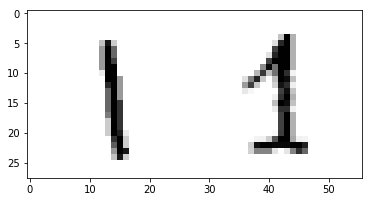

In [5]:

X_7 = HL.get_X_with_label(inputs, targets, 7)

plt.imshow(np.hstack((X_7[1].reshape((pixel_width,pixel_width)), X_7[2].reshape((pixel_width,pixel_width)))), cmap=plt.cm.binary)
plt.show()

X_1 = HL.get_X_with_label(inputs, targets, 1)

plt.imshow(np.hstack((X_1[1].reshape((pixel_width,pixel_width)), X_1[316].reshape((pixel_width,pixel_width)))), cmap=plt.cm.binary)
plt.show()

Here we can see some of the variations one could expect from handwritten digits. There are different types of writing. The seven can be written with or without a crossbar at the top image. Some ones are written with a bottom crossbar like the one to right some are not. These are just one of the variations we can occur in the 

## B. LLE

In [6]:
nb_components = 2
nb_neighbors =30

lle = manifold.LocallyLinearEmbedding(nb_neighbors, nb_components,
                                      method='standard')
X_lle = lle.fit_transform(inputs[0:nb_samples])

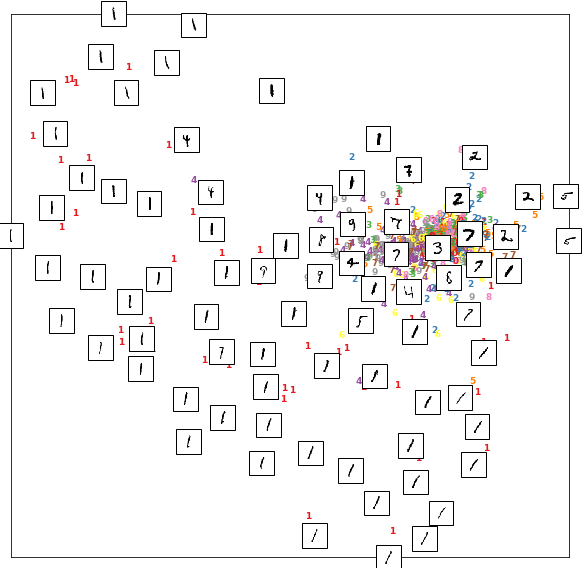

In [7]:

PL.plot_embedding(inputs, X_lle, targets[0:nb_samples])
plt.savefig("MNIST_lle_embedding")
plt.show()

We can see it discover some of the underlying structure in how we are writing the digits, but it is rather bad at finding the semantic value up the semantic

### Finding optimal parameters
- heatmap with nb_neighbors and regr.value with accuracy in each point


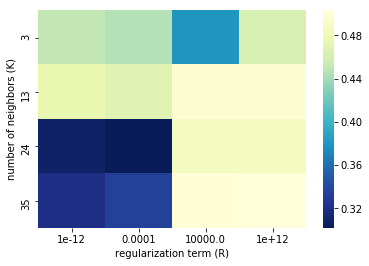

In [9]:
lle_dict = PK.kmeans_clustering_accuracy(inputs, targets, "lle", grid_width=4, nb_samples=nb_samples,
                                      reg_range=(-12, 12), neighbor_range=(3,35), plot=True, create=True)

## C. t-sne

In [10]:
#nb_samples = 3000
tsne = manifold.TSNE(n_components=2, perplexity=70.0, early_exaggeration=12.0, learning_rate=200.0, 
                     init='pca', random_state=123)
X_tsne = tsne.fit_transform(inputs[0:nb_samples])


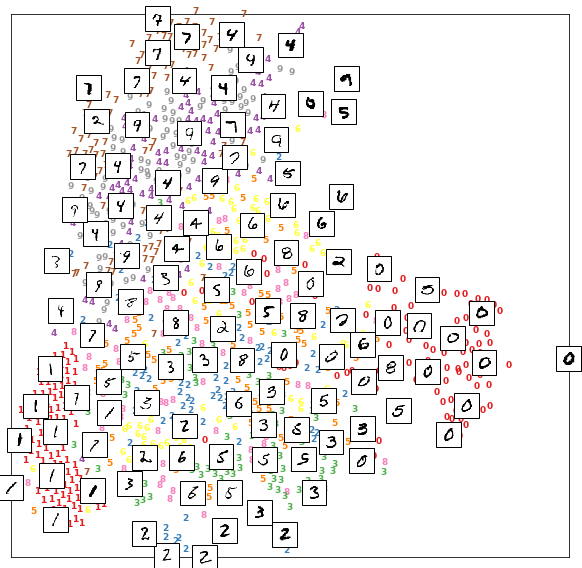

In [11]:

PL.plot_embedding(inputs, X_tsne, targets[0:nb_samples])
plt.savefig("MNIST_tsne_embedding")
plt.show()

### Finding optimal parameters
- heatmap with nb_neighbors and regr.value with accuracy in each point


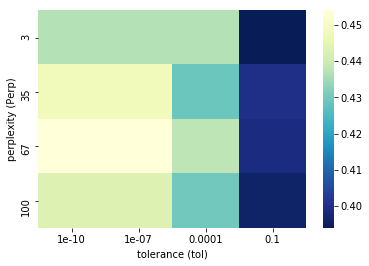

In [13]:
tsne_dict = PK.kmeans_clustering_accuracy(inputs, targets, "tsne", grid_width=4, nb_samples=nb_samples,
                                          min_grad_norm_range=(-10,-1), perplexity_range=(3,100), plot=True, create=True)


## D. Comparison